In [1]:
# Add submodule paths
import sys
import os
sys.path += ['./normalizing_flows', './baselines', './climdex']
# Optionally disable GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import shutil
import os
import climdex.temperature as tdex
import climdex.precipitation as pdex
import logging
import tensorflow_probability as tfp
import seaborn as sns
import experiments.maxt_experiment_base as maxt
import experiments.prcp_experiment_base as prcp
import utils.metrics as metrics
from experiments.common import upsample
from models.glow import build_jflvm
from baselines.dscnn import create_bmd_cnn10
from tensorflow.keras.models import load_model
from normalizing_flows.models import VariationalModel
from regions import southeast_us, pacific_nw
from datasource import EraiRasDataLoader
from utils.data import create_time_series_train_test_generator_v2
from utils.plot import image_map_factory, prcp_cmap
from utils.preprocessing import remove_monthly_means
from utils.distributions import normal, bernoulli_gamma
from tqdm import tqdm

correlation = metrics.correlation_metric()

gcs = gcsfs.GCSFileSystem(project='thesis-research-255223', token='gcs.secret.json')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg116 = xr.open_zarr(data.rasmussen('daily-1-16deg'), consolidated=True)
def get_train_test_splits(data_lo, data_hi, region_fn, scale, cv=False):
    data_lo = region_fn(data_lo)
    data_hi = region_fn(data_hi, scale_factor=scale)
    if cv:
        split_fn = create_time_series_train_test_generator_v2(n_splits=5, test_size=146)
        folds = list(split_fn(data_lo, data_hi))
        return folds
    else:
        lr_train = data_lo.isel(Time=slice(0,data_lo.Time.size-2*365))
        lr_test = data_lo.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
        hr_train = data_hi.isel(Time=slice(0,data_lo.Time.size-2*365))
        hr_test = data_hi.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
        return lr_train, lr_test, hr_train, hr_test

In [4]:
def download_jflvm(run_id, dirname, out_dir, fold=0, epoch=50, ckpt_num=10):
    os.makedirs(out_dir, exist_ok=True)
    filenames = [f'ckpt-{ckpt_num}.index', f'ckpt-{ckpt_num}.data-00000-of-00002', f'ckpt-{ckpt_num}.data-00001-of-00002']
    for filename in filenames:
        with gcs.open(f'gs://generative-downscaling-artifact-store/glow-jflvm-final/{run_id}/artifacts/model/{dirname}/{filename}') as src:
            with open(f'{out_dir}/{filename}', 'wb') as dst:
                shutil.copyfileobj(src, dst)
                
def download_bmd(run_id, out_dir, epoch=50):
    os.makedirs(out_dir, exist_ok=True)
    filename = f'bmd-epoch{epoch}.h5'
    with gcs.open(f'gs://generative-downscaling-artifact-store/bmd-final/{run_id}/artifacts/model/{filename}') as src:
        with open(f'{out_dir}/{filename}', 'wb') as dst:
            shutil.copyfileobj(src, dst)
    return load_model(f'{out_dir}/{filename}')

def slerp(z1, z2, steps=4):
    assert z1.shape[0] == 1 and z2.shape[0] == 1, 'slerp only supported for one sample at a time'
    shape = z1.shape
    t = np.linspace(0.,1.,steps).reshape((steps,1))
    z1, z2 = tf.reshape(z1, (z1.shape[0],-1)), tf.reshape(z2, (z2.shape[0],-1))
    omega = tf.math.acos(tf.math.reduce_sum(z1/tf.norm(z1)*z2/tf.norm(z2)))
    sin_omega = tf.math.sin(omega)
    interpolated = tf.math.sin((1.0-t)*omega) / sin_omega * z1 + tf.math.sin(t*omega)/sin_omega * z2
    return tf.reshape(interpolated, (steps, *shape[1:]))

def sample_prediction(x, model, sigma=0.5, n=100):
    z, p_x = model.encode_x(x, return_log_prob=True)
    _, p_y = model.decode_y(z, return_log_prob=True)
    eps = tf.random.normal((n,*z.shape[1:]), stddev=sigma)
    x_, p_zx = model.decode_x(z+eps, return_log_prob=True)
    y_, p_zy = model.decode_y(z+eps, return_log_prob=True)
    return x_, y_, (p_zx, p_zy, p_x, p_y)

#### Max temperature

In [5]:
erai_deg1_arr = erai_deg1[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
ras_deg14_arr = ras_deg14[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1_arr, ras_deg14_arr, southeast_us, scale=4)
data_fold = maxt.preprocess_fold_maxt(((lr_train, hr_train),(lr_test, hr_test)))
train_lo, train_hi = data_fold.train
test_lo, test_hi = data_fold.test
N_train, N_test = train_lo.Time.size, test_lo.Time.size
(wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
monthly_means_lo, monthly_means_hi = data_fold.monthly_means
test_ds_paired = data_fold.test_dataset(batch_size=10, buffer_size=1000,
                                        map_fn_lo=upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR),
                                        mode='test')
model_joint = build_jflvm((None,wt_hi,ht_hi,1), scale=4, layers=3, depth=8,
                          min_filters=32, max_filters=256,
                          dnet_layers=3, dnet_filters=64)
model_joint.load('data/saved_models/glow-jflvm/maxt-seus/ckpt', 8)

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


In [6]:
x, y = next(test_ds_paired.__iter__())
y_pred = model_joint.predict_y(x)

In [14]:
(x_, p_x), (y_, p_y) = model_joint.sample(n=1000, return_log_prob=True)
(z_x, p_zx), (z_y, p_zy) = model_joint.encode_x(x, return_log_prob=True), model_joint.encode_y(y, return_log_prob=True)

<Figure size 648x360 with 0 Axes>

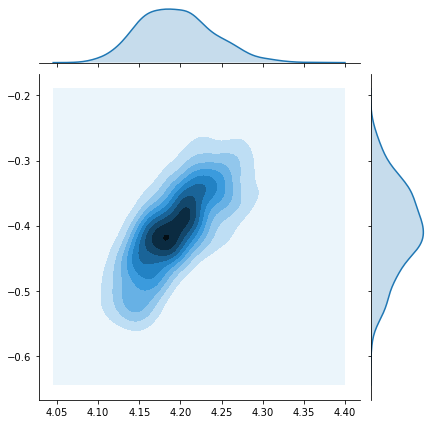

In [16]:
plt.figure(figsize=(9,5))
sns.jointplot(x=p_x, y=p_y, kind='kde')
ax = plt.gca()

In [9]:
x_samples, y_samples, (p_sx, p_sy, p_x, p_y) = sample_prediction(x[:1], model_joint, sigma=0.5, n=1000)
print(p_x, p_y)

tf.Tensor([4.7271814], shape=(1,), dtype=float32) tf.Tensor([0.27146125], shape=(1,), dtype=float32)


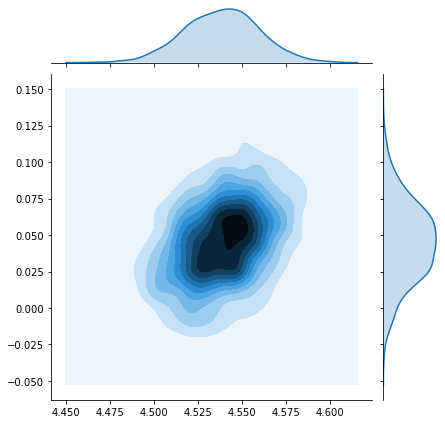

In [10]:
sns.jointplot(x=p_sx, y=p_sy, kind='kde')

In [11]:
z_x, log_prob_x = model_joint.encode_x(x, return_log_prob=True)
z_y, log_prob_y = model_joint.encode_y(y, return_log_prob=True)
z_yp, log_prob_yp = model_joint.encode_y(y_samples, return_log_prob=True)

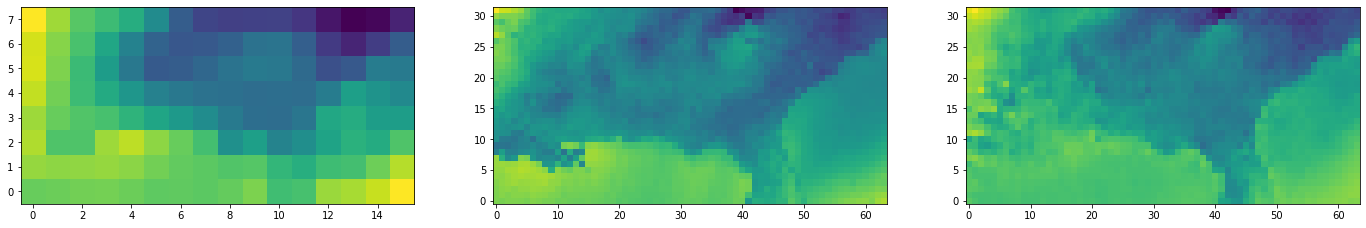

In [12]:
plt.figure(figsize=(3*8,6))
plt.subplot(1,3,1)
plt.imshow(tf.squeeze(tf.image.resize(x[0], (wt,ht), method='nearest')).numpy(), origin='lower')
plt.subplot(1,3,2)
plt.imshow(tf.squeeze(y[0]).numpy(), origin='lower')
plt.subplot(1,3,3)
plt.imshow(tf.squeeze(y_pred[0]).numpy(), origin='lower')

In [17]:
zs = slerp(z_y[:1], z_y[9:10], steps=100)
x_interp, p_xi = model_joint.decode_x(zs, return_log_prob=True)
y_interp, p_yi = model_joint.decode_y(zs, return_log_prob=True)

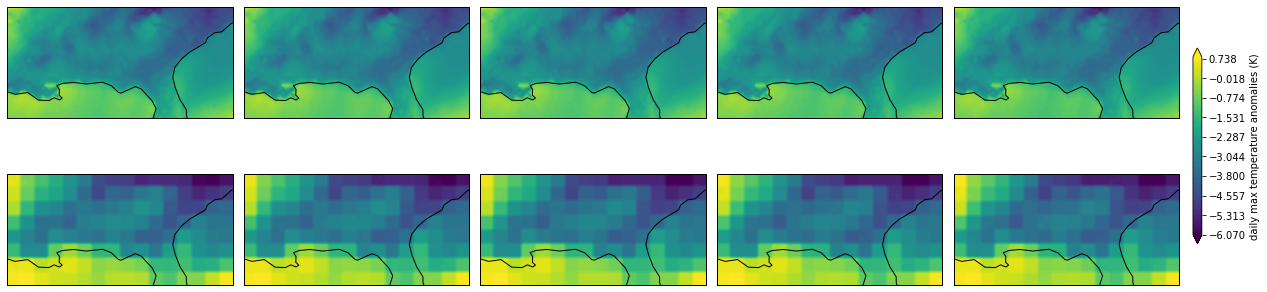

In [18]:
fig, axs, plot_fn = image_map_factory(2, 5, figsize=(5,3))
plot_fn(axs[0,0], y_interp[0].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
plot_fn(axs[0,1], y_interp[1].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
plot_fn(axs[0,2], y_interp[2].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
plot_fn(axs[0,3], y_interp[3].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
plot_fn(axs[0,4], y_interp[4].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
plot_fn(axs[1,0], x_interp[0].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
plot_fn(axs[1,1], x_interp[1].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
plot_fn(axs[1,2], x_interp[2].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
plot_fn(axs[1,3], x_interp[3].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
cs = plot_fn(axs[1,4], x_interp[4].numpy().squeeze(), hr_test.lat, hr_test.lon, cmap='viridis')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('daily max temperature anomalies (K)')
plt.show()

#### Precipitation

In [ ]:
erai_deg1_arr = prcp.preprocess_dataset(erai_deg1[['PRCP']], erai_deg1['PRCP'].shape)
erai_deg1_arr = erai_deg1_arr.to_array('chan').transpose('Time','lat','lon','chan')
ras_deg14_arr = prcp.preprocess_dataset(ras_deg14[['PRCP']], ras_deg14['PRCP'].shape)
ras_deg14_arr = ras_deg14_arr.to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1_arr, ras_deg14_arr, southeast_us, scale=4)
data_fold = prcp.preprocess_fold_prcp(((lr_train, hr_train),(lr_test, hr_test)))
train_lo, train_hi = data_fold.train
test_lo, test_hi = data_fold.test
N_train, N_test = train_lo.Time.size, test_lo.Time.size
(wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
test_ds_paired = data_fold.test_dataset(batch_size=10, buffer_size=1000,
                                        map_fn_lo=upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR),
                                        supervised=True)
model_joint_prcp = build_jflvm((None,wt_hi,ht_hi,1), scale=4, layers=3, depth=4,
                               min_filters=32, max_filters=256,
                               dnet_layers=3, dnet_filters=64)
model_joint_prcp.load('data/saved_models/glow-jflvm/prcp-seus/ckpt', 10)

In [ ]:
x, y = next(test_ds_paired.__iter__())
y_pred = model_joint_prcp.predict_y(x[:1])
y_samples,_,_ = sample_prediction(x[:1], model_joint_prcp, sigma=0.5)
y_samples = y_samples**3
y_samples = tf.where(y_samples > 5.0, y_samples, 0.0)
x, y, y_pred = x**3, y**3, y_pred**3
x = tf.image.resize(x, (wt,ht), method='nearest')

In [ ]:
fig, axs, plot_fn = image_map_factory(2, 3, figsize=(6,4))
pmap = prcp_cmap()
plot_fn(axs[0,0], x[0].numpy().squeeze(), lr_test.lat, lr_test.lon, title='ERA-I', cmap=pmap)
plot_fn(axs[0,1], y[0].numpy().squeeze(), hr_test.lat, hr_test.lon, title='WRF-4', cmap=pmap)
plot_fn(axs[0,2], y_pred[0].numpy().squeeze(), hr_test.lat, hr_test.lon, title='Predicted', cmap=pmap)
plot_fn(axs[1,0], y_samples[0].numpy().squeeze(), hr_test.lat, hr_test.lon, title='Sample 1', cmap=pmap)
plot_fn(axs[1,1], y_samples[1].numpy().squeeze(), hr_test.lat, hr_test.lon, title='Sample 2', cmap=pmap)
cs = plot_fn(axs[1,2], y_samples[2].numpy().squeeze(), hr_test.lat, hr_test.lon, title='Sample 3', cmap=pmap)
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('daily precip (mm)')

#### Anomaly likelihood analysis

In [ ]:
upper_quartile = test_hi.chunk({'Time': -1}).quantile(0.75, dim='Time')
lower_quartile = test_hi.chunk({'Time': -1}).quantile(0.25, dim='Time')
out_iqr_counts = xr.ufuncs.logical_or(test_hi > upper_quartile, test_hi < lower_quartile).sum(dim=['lat','lon']).compute()
inds = out_iqr_counts.squeeze().argsort(axis=0)
lr_sorted = test_lo[inds.values]
lr_vals = tf.image.resize(lr_sorted.values.astype(np.float32), (wt_hi,ht_hi), method='nearest')

In [ ]:
zp, p_x = model_joint.encode_x(lr_vals, return_log_prob=True)
yp, p_y = model_joint.decode_y(zp, return_log_prob=True)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(2*8,5), sharex=True)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Spatial anomaly count")
sns.scatterplot(x=anomaly_counts, y=p_x, ax=axs[0])
axs[0].set(ylabel='Log likelihood')
sns.scatterplot(x=anomaly_counts, y=p_y, ax=axs[1])
plt.tight_layout()